In [1]:
import geopandas as gpd
from pathlib import Path
import warnings
import hvplot.xarray
import pandas as pd
import xarray as xr
import numpy as np

import networkx as nx
import geonetworkx as gnx

warnings.filterwarnings("ignore")

In [2]:
river_network_fn = Path('/tiger1/pdas47/ResORR-revision/data-cumberland/cumberland_rivreg_usace/rivreg.geojson')
river_network_pts_fn = Path('/tiger1/pdas47/ResORR-revision/data-cumberland/cumberland_rivreg_usace/rivreg_pts.geojson')

river_network = gpd.read_file(river_network_fn)
river_network.to_xarray()

river_network_pts = gpd.read_file(river_network_pts_fn)
river_network_pts.to_xarray()

<xarray.Dataset> Size: 384B
Dimensions:   (index: 8)
Coordinates:
  * index     (index) int64 64B 0 1 2 3 4 5 6 7
Data variables:
    x         (index) object 64B '-88.21874800000001' ... '-85.944131'
    y         (index) object 64B '37.018747' '36.959995' ... '36.29222'
    name      (index) object 64B 'Barkley_Dam' ... 'Cordell_Hull_Dam'
    id        (index) int64 64B 0 1 2 3 4 5 6 7
    geometry  (index) object 64B POINT (-88.218748 37.018747) ... POINT (-85....

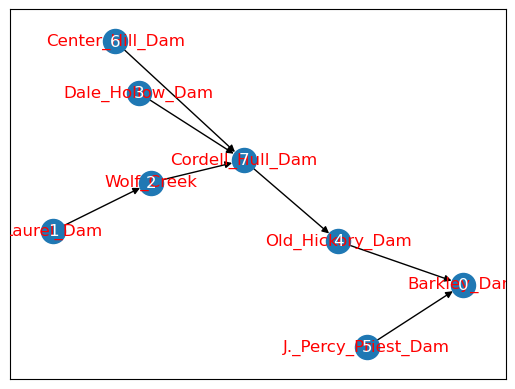

In [3]:
# quick and simple implementation without landlab

G = gnx.read_geofiles(river_network_pts_fn, river_network_fn, directed=True)
# nx.draw(G, nx.drawing.planar_layout(G))
pos = nx.drawing.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, labels={node:G.nodes[node]['name'] for node in G.nodes},font_color='red')
nx.draw_networkx_labels(G, pos,font_color='white');

# Compile data for river-regulation model

The following cells will workf if the `final_outputs` of RAT are being used. The `final_outputs` get created in the last step of RAT, which may or may not run based on the status of the previous steps. If it did run, use the following cells, otherwise, use the next section.

In [5]:
RUN_TYPE = 'S1'

start_date = "2018-01-01"
end_date = "2019-09-30"

rat_output_dir = Path("/tiger1/pdas47/ResORR-revision/data-cumberland/tennessee-calibrated-era5-2015_2021/basins/cumberland/rat_outputs")
unregulated_inflow_dir = rat_output_dir / "inflow"

regulation_data_fn = Path("/tiger1/pdas47/ResORR-revision/data-cumberland/regulation-data/insitu.2018-2019.nc")
regulation_data_fn.parent.mkdir(exist_ok=True)
regulation_data_output_fn = regulation_data_fn.with_suffix(f".regulated.{RUN_TYPE}.nc")

insitu_dir = Path("/tiger1/pdas47/ResORR-revision/data-cumberland/insitu")  # observed ∆S, I, O

In [10]:
from bokeh.models.formatters import NumeralTickFormatter

# Prepare regulation input
# Code to make the regulation_data.nc file.
def read_unregulated_inflow(unregulated_inflow_fn, node_id, rat_output_level='final_outputs') -> xr.Dataset:
    """returns inflow files generated by RAT under pristine conditions as unregulated inflow.

    Args:
        unregulated_inflow_fn (str): path of the unregulated inflow file
        rat_output_level (str, optional): whether to read from `final_outputs` or `rat_outputs`, which are slightly different in units and file formatting. Defaults to 'final_outputs'.

    Returns:
        xr.Dataset: unregulated inflow
    """
    if rat_output_level == 'final_outputs':
        unregulated_inflow = pd.read_csv(unregulated_inflow_fn, parse_dates=['date']).rename({
            'date': 'time',
            'inflow (m3/d)': 'unregulated_inflow'
            }, axis='columns')
    elif rat_output_level == 'rat_outputs':
        unregulated_inflow = pd.read_csv(unregulated_inflow_fn, parse_dates=['date']).rename({
            'date': 'time',
            'streamflow': 'unregulated_inflow'
            }, axis='columns')
        unregulated_inflow['unregulated_inflow'] = unregulated_inflow['unregulated_inflow'] * (24*60*60) # m3/s -> m3/day

    unregulated_inflow['node'] = node_id
    unregulated_inflow.set_index(['time', 'node'], inplace=True)
    unregulated_inflow = unregulated_inflow.to_xarray()

    return unregulated_inflow

def read_storage_change_rat(storage_change_fn, node_id):
    storage_change = pd.read_csv(storage_change_fn, parse_dates=['date']).rename({
        'date': 'time',
        'dS': 'storage_change'
    }, axis='columns')[['time', 'storage_change']] * 

    # convert storage_change to daily - https://stackoverflow.com/a/73724900
    storage_change = storage_change.set_index('time')
    storage_change = storage_change.resample('1D').apply(lambda x: np.nan if x.empty else x)
    groups = storage_change['storage_change'].notna()[::-1].cumsum()
    storage_change['storage_change'] = storage_change['storage_change'].fillna(0).groupby(groups).transform('mean')
    storage_change['node'] = node_id
    storage_change = storage_change.reset_index().set_index(['time', 'node'])
    storage_change = storage_change.to_xarray()

    return storage_change

def read_insitu(insitu_fn, node_id):
    dels_derived = False
    
    insitu = pd.read_csv(insitu_fn, parse_dates=['date']).rename({'date': 'time'}, axis=1)

    insitu['node'] = node_id
    
    to_merge = []
    # observed inflow
    obs_inflow = insitu[['time', 'node', 'inflow']].rename({'inflow': 'obs_inflow'}, axis=1)
    obs_inflow.set_index(['time', 'node'], inplace=True)
    obs_inflow = obs_inflow.to_xarray() * (24*60*60) # m3/s -> m3/day
    to_merge.append(obs_inflow)

    # observed outflow (if available)
    if 'outflow' in insitu.columns:
        obs_outflow = insitu[['time', 'node', 'outflow']].rename({'outflow': 'obs_outflow'}, axis=1)
        obs_outflow.set_index(['time', 'node'], inplace=True)
        obs_outflow = obs_outflow.to_xarray() * (24*60*60) # m3/s -> m3/day
        to_merge.append(obs_outflow)

    if not 'storage_change' in insitu.columns:
        obs_storage_change = insitu[['time', 'node', 'storage']].rename({'storage': 'obs_storage_change'}, axis=1)
        obs_storage_change.set_index(['time', 'node'], inplace=True)
        obs_storage_change['obs_storage_change'] = obs_storage_change['obs_storage_change'] * 1e6  # MCM to CM
        obs_storage_change['obs_storage_change'] = obs_storage_change['obs_storage_change'].diff()
    else:
        obs_storage_change = insitu[['time', 'node', 'storage_change']].rename({'storage_change': 'obs_storage_change'}, axis=1)
        obs_storage_change.set_index(['time', 'node'], inplace=True)
        obs_storage_change['obs_storage_change'] = obs_storage_change['obs_storage_change'] * 1e6 # MCM to CM

    obs_storage_change = obs_storage_change.to_xarray()
    to_merge.append(obs_storage_change)

    return xr.merge(to_merge)


datasets_to_join = []

for node_id in G:
    node = G.nodes[node_id]
    name = node['name']

    # unregulated inflow
    unregulated_inflow_fn = unregulated_inflow_dir / f"{name}.csv"
    rat_output_level = unregulated_inflow_dir.parts[-2]

    if not unregulated_inflow_fn.exists():
        print(f"Missing {unregulated_inflow_fn}")
        continue
    unregulated_inflow = read_unregulated_inflow(unregulated_inflow_fn, node_id, rat_output_level=rat_output_level)
    datasets_to_join.append(unregulated_inflow)

    # insitu data
    insitu_fn = insitu_dir / f"{name}.csv"
    insitu = read_insitu(insitu_fn, node_id)
    datasets_to_join.append(insitu)


regulation_data = xr.merge(datasets_to_join).sel(time=slice(start_date, end_date))
regulation_data

<xarray.Dataset> Size: 168kB
Dimensions:             (time: 638, node: 8)
Coordinates:
  * time                (time) datetime64[ns] 5kB 2018-01-01 ... 2019-09-30
  * node                (node) int64 64B 0 1 2 3 4 5 6 7
Data variables:
    unregulated_inflow  (time, node) float64 41kB 1.419e+08 ... 1.111e+06
    obs_inflow          (time, node) float64 41kB 1.313e+08 ... 7.098e+06
    obs_outflow         (time, node) float64 41kB 1.589e+08 ... 1.125e+07
    obs_storage_change  (time, node) float64 41kB -3.056e+07 ... -4.159e+06

In [7]:
regulation_data.sel(node=5).hvplot(x='time', y='unregulated_inflow', label='modeled') * \
regulation_data.sel(node=5).hvplot(x='time', y='obs_inflow', label='insitu')

:Overlay
   .Curve.Modeled :Curve   [time]   (unregulated_inflow)
   .Curve.Insitu  :Curve   [time]   (obs_inflow)

In [6]:
regulation_data.to_netcdf(regulation_data_output_fn)

NameError: name 'regulation_data' is not defined

# create regualtion dataset using satellite derived storage changes

In [11]:
storage_change_dir = Path("/tiger1/pdas47/ResORR/data-cumberland/tennessee/basins/cumberland/rat_outputs/dels")

datasets_to_join = []

for node_id in G:
    node = G.nodes[node_id]
    name = node['name']

    # natural inflow
    unregulated_inflow_fn = unregulated_inflow_dir / f"{name}.csv"
    if not unregulated_inflow_fn.exists():
        print(f"Missing {unregulated_inflow_fn}")
        continue
    unregulated_inflow = read_unregulated_inflow(unregulated_inflow_fn, node_id, rat_output_level='rat_outputs')
    datasets_to_join.append(unregulated_inflow)
    
    # storage change
    storage_change_fn = storage_change_dir / f"{name}.csv"
    if storage_change_fn.exists():
        storage_change = read_storage_change_rat(storage_change_fn, node_id,)
        datasets_to_join.append(storage_change)

    # insitu data
    insitu_fn = insitu_dir / f"{name}.csv"
    insitu = read_insitu(insitu_fn, node_id)
    datasets_to_join.append(insitu)

regulation_data = xr.merge(datasets_to_join).sel(time=slice(start_date, end_date))
regulation_data

<xarray.Dataset> Size: 209kB
Dimensions:             (time: 638, node: 8)
Coordinates:
  * time                (time) datetime64[ns] 5kB 2018-01-01 ... 2019-09-30
  * node                (node) int64 64B 0 1 2 3 4 5 6 7
Data variables:
    unregulated_inflow  (time, node) float64 41kB 1.419e+08 ... 1.111e+06
    storage_change      (time, node) float64 41kB nan nan ... 0.01694 -0.0002608
    obs_inflow          (time, node) float64 41kB 1.313e+08 ... 7.098e+06
    obs_outflow         (time, node) float64 41kB 1.589e+08 ... 1.125e+07
    obs_storage_change  (time, node) float64 41kB -3.056e+07 ... -4.159e+06

In [12]:
regulation_data.sel(node=2).hvplot(x='time', y='storage_change', label='modeled')

:Curve   [time]   (storage_change)

In [26]:
rat_dels_hv = regulation_data.sel(time=slice('2018-01-01', '2019-03-01'), node=6).hvplot('time', 'storage_change').opts(yformatter=NumeralTickFormatter(format='0.0 a'))
obs_dels_hv = regulation_data.sel(time=slice('2018-01-01', '2019-03-01'), node=6).hvplot('time', 'obs_storage_change').opts(yformatter=NumeralTickFormatter(format='0.0 a'))
# obs_inflow_hv = regulation_data.sel(time=slice('2018-01-01', '2019-03-01'), node=6).hvplot('time', 'obs_inflow').opts(yformatter=NumeralTickFormatter(format='0.0 a'))
# obs_outflow_hv = regulation_data.sel(time=slice('2018-01-01', '2019-03-01'), node=6).hvplot('time', 'obs_outflow').opts(yformatter=NumeralTickFormatter(format='0.0 a'))


# rat_dels_hv * obs_dels_hv * obs_inflow_hv * obs_outflow_hv
rat_dels_hv * obs_dels_hv # * obs_inflow_hv * obs_outflow_hv

:Overlay
   .Curve.I  :Curve   [time]   (storage_change)
   .Curve.II :Curve   [time]   (obs_storage_change)

In [13]:
regulation_data_fn = Path('/tiger1/pdas47/ResORR-revision/data-cumberland/regulation-data/RAT.2019-2019.regulated.S2.nc')

regulation_data.to_netcdf(regulation_data_fn)